# Why sequence seems to be lost

Expanding Aug24 analysis to examine why sequence seems to be lost with synaptic input error rule

Weds, Aug 25, 2021

In [103]:
import brian2 as b2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import PIN_ntwk as pn
from utils import kth_diag_indices, generate_target_seq
import importlib
importlib.reload(pn)

<module 'PIN_ntwk' from 'C:\\Users\\vyomr\\Desktop\\Fairhall_code\\chain\\PIN_ntwk.py'>

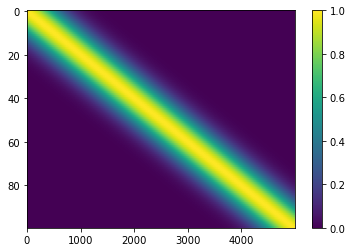

In [2]:
N_neurons = 100
duration = 5*b2.second
dt = 1*b2.ms
n_timesteps = int(duration/dt)

arr_rates_ideal, arr_target_fx = generate_target_seq(N_neurons, n_timesteps, dt, std=0.3)

plt.imshow(arr_rates_ideal, aspect='auto')
plt.colorbar()

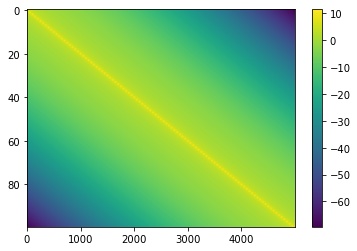

In [53]:
plt.imshow(arr_target_fx, aspect='auto')
plt.colorbar()

## Why sequence lost with syntot rule

In [117]:
tau_neuron = 10*b2.ms
c_net = pn.PIN_ntwk(N_neurons, tau_neuron, duration, dt, n_timesteps, 
                 g_wt_variance=1.5, theta=0, seed=0)

c_net.generate_frozen_external_input(tau_wn=1*b2.second, h0_wn=1)
c_net.generate_weights()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:22<00:00,  1.05s/it]


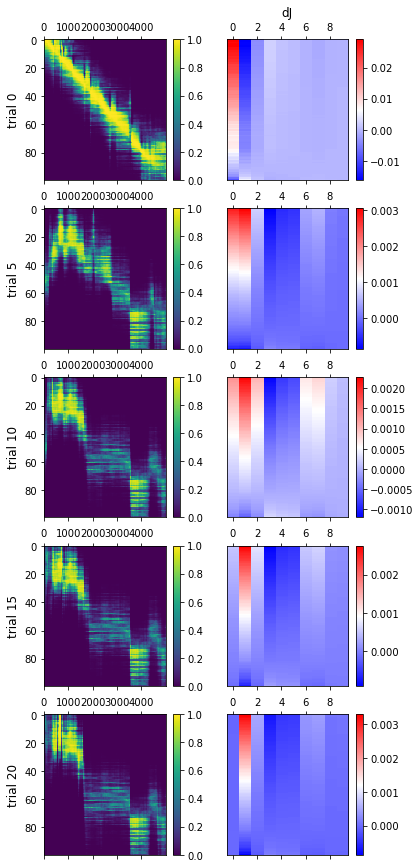

In [135]:
c_net.train(arr_target_fx=arr_target_fx, p_plastic=0.1, alpha=1, n_training_steps=21, n_plot_every=5,
              rule='syntot', seed=0, b_inject_noise=False, amp_noise=0.1)
plt.savefig('../chain_output_imgs/Aug25_PINning_syntotrule_p10.png', bbox_inches='tight')

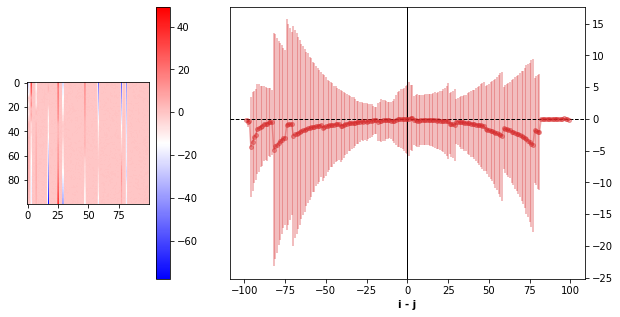

In [136]:
c_net.plot_band_structure()

In [137]:
c_net.arr_dJ_mag.shape

(21, 5000)

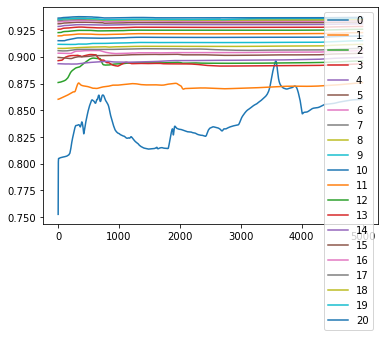

In [138]:
for idx_learn in range(21):
    plt.plot(c_net.arr_dJ_mag[idx_learn, 1:], label=idx_learn)
plt.legend()

Okay... so weight updates keep happening after each trial

In [139]:
test_output = c_net.run(arr_target_fx)

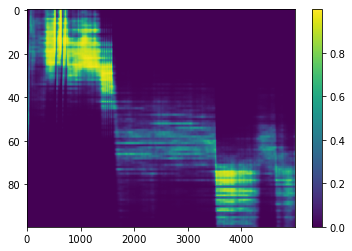

In [140]:
# returns neuron_output_x, neuron_output_rate, neuron_output_syntot, neuron_error
plt.imshow(test_output[1], aspect='auto')
plt.colorbar()

Output at different timepoints with paused learning in first trial

In [141]:
c_net.arr_plastic_neurons

array([77, 81, 58, 47, 25,  3,  1, 29, 17,  7])

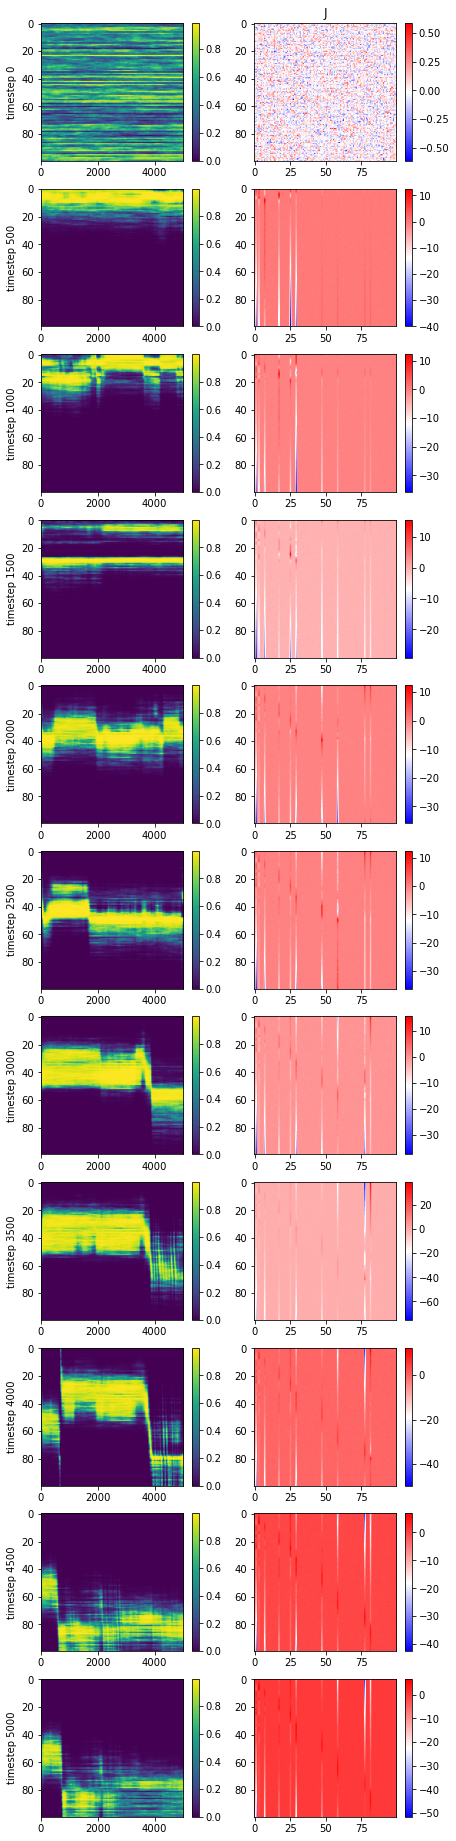

In [142]:
neuron_output_x = np.zeros((c_net.N_neurons, c_net.n_timesteps))
neuron_output_rate = np.zeros((c_net.N_neurons, c_net.n_timesteps))
neuron_output_syntot = np.zeros((c_net.N_neurons, c_net.n_timesteps))
neuron_error = np.zeros((c_net.N_neurons, c_net.n_timesteps))

arr_optimize = neuron_output_syntot

arr_J = c_net.arr_J_init.copy()
arr_P = c_net.arr_P_init.copy()
n_rows = int(c_net.n_timesteps/500) + 1
f, axs = plt.subplots(ncols=2, nrows=n_rows, figsize=(7, 3*n_rows))
idx_row = 0
for idx_t in range(1, c_net.n_timesteps):
    c_net.arr_J_learned = arr_J
    # Plot run outputs every few timesteps
    if ((idx_t+1) % 500) == 0 or idx_t==1:
        test_output = c_net.run(arr_target_fx)        
        
        mappable = axs[idx_row, 0].imshow(test_output[1], aspect='auto')
        plt.colorbar(mappable, ax=axs[idx_row, 0])
        if idx_t == 1:
            axs[idx_row, 0].set_ylabel('timestep {}'.format(0))
            axs[idx_row, 1].set_title('J')
        else:
            axs[idx_row, 0].set_ylabel('timestep {}'.format(idx_t+1))
        
        mappable = axs[idx_row, 1].imshow(arr_J, aspect='auto', cmap='bwr')
        plt.colorbar(mappable, ax=axs[idx_row, 1])
        idx_row+=1
        
    x = neuron_output_x[:, idx_t - 1]

    neuron_output_rate[:, idx_t] = 1 / (1 + np.exp(-(x - c_net.theta)))
    arr_r = neuron_output_rate[:, idx_t].reshape(c_net.N_neurons, 1)

    neuron_output_syntot[:, idx_t] = (arr_J @ arr_r).reshape(c_net.N_neurons)

    neuron_output_x[:, idx_t] = x + c_net.dt * (-x + c_net.external_input[:, idx_t] \
                                               + neuron_output_syntot[:, idx_t]) / c_net.tau_neuron

    neuron_error[:, idx_t] = arr_optimize[:, idx_t] - arr_target_fx[:, idx_t]
    arr_e = neuron_error[:, idx_t].reshape(c_net.N_neurons, 1)

    # wt learning
    arr_Pr = (arr_P @ arr_r[c_net.arr_plastic_neurons])  # NxN_p@N_px1
    arr_rPr = arr_r[c_net.arr_plastic_neurons].T @ arr_Pr[c_net.arr_plastic_neurons]  # 1xN_p@N_px1
    arr_c = 1.0 / (1.0 + arr_rPr)  # 1 x 1

    # Update P and J
    arr_P -= arr_c * (arr_Pr @ arr_r[c_net.arr_plastic_neurons].T @ arr_P[c_net.arr_plastic_neurons, :])  # c * Nx1@1xN_p@N_pxN_p
    arr_dJ = arr_c * (arr_e @ arr_Pr[c_net.arr_plastic_neurons].T)  # c * Nx1@1xN_p
    arr_J[:, c_net.arr_plastic_neurons] -= arr_dJ
    c_net.arr_dJ_mag[idx_learn, idx_t] = np.sum(np.abs(arr_J - c_net.arr_J_init))/np.sum(np.abs(arr_J))
plt.savefig('../chain_output_imgs/syntoterror_p0.1_trial0.png', bbox_inches='tight')

pvar implementation

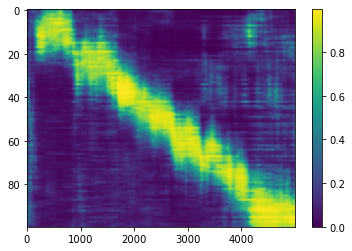

In [48]:
test_output = c_net.run(arr_rates_ideal, rule='rate', b_inject_noise=False, amp_noise=0.001)
plt.imshow(test_output[1], aspect='auto')
plt.colorbar()

In [49]:
def get_pvar(arr_target_fx, arr_net_output):
    n_error_norm = np.linalg.norm(arr_rates_ideal - arr_net_output, ord='fro')
    n_var_norm = np.linalg.norm(arr_target_fx - arr_target_fx.mean(axis=0), ord='fro')
    
    return 1 - (n_error_norm/n_var_norm)

In [50]:
get_pvar(arr_rates_ideal, test_output[1])

0.5432620615711965

0.12799914995612915

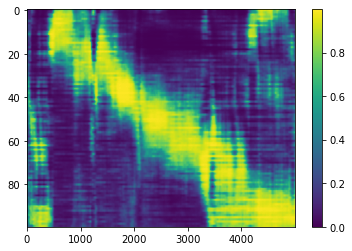

In [52]:
test_output = c_net.run(arr_rates_ideal, rule='rate', b_inject_noise=True, amp_noise=0.01)
plt.imshow(test_output[1], aspect='auto')
plt.colorbar()
get_pvar(arr_rates_ideal, test_output[1])